In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import timm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
data_dir = r'C:\Users\Demyd Zaborskyi\.cache\kagglehub\datasets\itsahmad\indoor-scenes-cvpr-2019\versions\1\indoorCVPR_09\Images'

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Середні та STD для ImageNet
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

batch_size = 32

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
)

num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 67


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available. CPU is being used.")

GPU: NVIDIA GeForce RTX 4070


In [5]:
model_res2net = timm.create_model('res2net50_26w_4s', pretrained=True)

in_features = model_res2net.get_classifier().in_features
model_res2net.fc = nn.Linear(in_features, num_classes)

model_res2net.to(device)


model.safetensors:   0%|          | 0.00/103M [00:00<?, ?B/s]

C:\Anaconda\envs\cuda_test\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Demyd Zaborskyi\.cache\huggingface\hub\models--timm--res2net50_26w_4s.in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottle2neck(
      (conv1): Conv2d(64, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (convs): ModuleList(
        (0-2): 3 x Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bns): ModuleList(
        (0-2): 3 x BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (pool): AvgPool2d(kernel_size=3, stride=1, padding=1)
      (conv3): Conv2d(104, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_run

In [6]:
criterion_res2net = nn.CrossEntropyLoss()

optimizer_res2net = optim.AdamW(model_res2net.parameters(), lr=1e-4, weight_decay=1e-4)


In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                device, num_epochs=10, model_name='model'):
    best_val_acc = 0.0
    total_training_time = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(inputs)

                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total

        end_time = time.time()
        epoch_time = end_time - start_time
        total_training_time += epoch_time

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f} | "
              f"Time: {epoch_time:.2f}s")

        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), f'best_{model_name}.pth')

    print(f"Best validation for {model_name}: {best_val_acc:.4f}")
    print(f"Training time {model_name}: {total_training_time:.2f}s")
    return total_training_time

In [8]:
print("\n=== Training of Res2Net ===")
training_time_res2net = train_model(
    model=model_res2net,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_res2net,
    optimizer=optimizer_res2net,
    device=device,
    num_epochs=10,
    model_name='model_res2net50_26w_4s'
)



=== Training of Res2Net ===
Epoch 1/10 | Train Loss: 1.9335 | Train Acc: 0.5244 | Val Loss: 1.0453 | Val Acc: 0.6901 | Time: 87.04s
Epoch 2/10 | Train Loss: 0.7526 | Train Acc: 0.7966 | Val Loss: 0.8483 | Val Acc: 0.7593 | Time: 81.03s
Epoch 3/10 | Train Loss: 0.3652 | Train Acc: 0.9029 | Val Loss: 0.9300 | Val Acc: 0.7452 | Time: 78.15s
Epoch 4/10 | Train Loss: 0.2109 | Train Acc: 0.9414 | Val Loss: 0.9557 | Val Acc: 0.7375 | Time: 70.75s
Epoch 5/10 | Train Loss: 0.1498 | Train Acc: 0.9599 | Val Loss: 1.0409 | Val Acc: 0.7362 | Time: 73.15s
Epoch 6/10 | Train Loss: 0.1440 | Train Acc: 0.9601 | Val Loss: 0.9865 | Val Acc: 0.7482 | Time: 58.20s
Epoch 7/10 | Train Loss: 0.1220 | Train Acc: 0.9658 | Val Loss: 1.0642 | Val Acc: 0.7379 | Time: 58.14s
Epoch 8/10 | Train Loss: 0.1194 | Train Acc: 0.9657 | Val Loss: 1.0926 | Val Acc: 0.7392 | Time: 58.20s
Epoch 9/10 | Train Loss: 0.0999 | Train Acc: 0.9709 | Val Loss: 0.9858 | Val Acc: 0.7627 | Time: 58.35s
Epoch 10/10 | Train Loss: 0.0875 | 

In [9]:
def evaluate_model(model, test_loader, device, class_names, model_name='model'):
    model.eval()
    all_preds = []
    all_labels = []
    inference_times = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            start_time = time.time()
            outputs = model(inputs)
            end_time = time.time()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            inference_times.append(end_time - start_time)

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    recall = recall_score(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    f1 = f1_score(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    avg_inference_time = sum(inference_times) / len(inference_times)

    print(f"\nMetrics {model_name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Inference time: {avg_inference_time:.6f} s")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=class_names, yticklabels=class_names
    )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return acc, precision, recall, f1, avg_inference_time, cm


=== Evaluation of Res2Net ===

Metrics Res2Net50_26w_4s:
Accuracy: 0.7482
Precision: 0.7580
Recall: 0.7482
F1-Score: 0.7451
Inference time: 0.008304 s


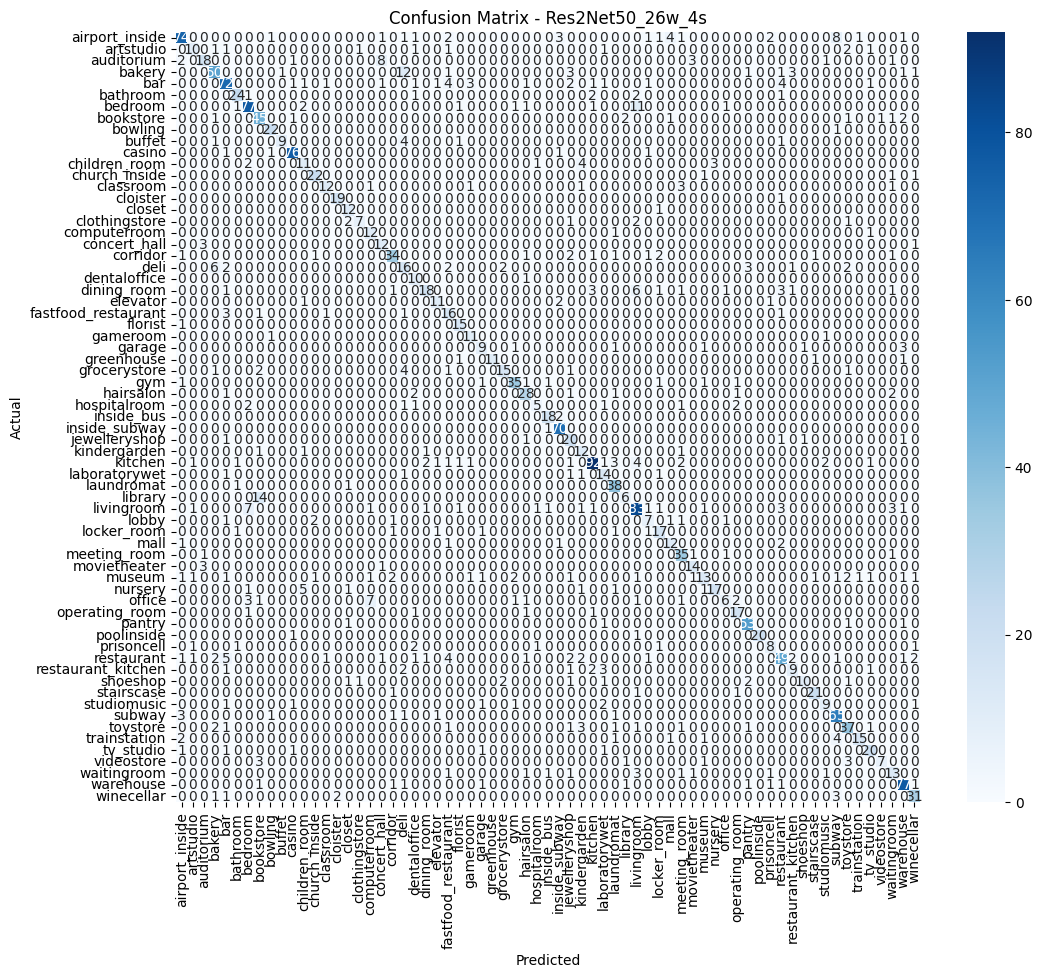


Res2Net50_26w_4s - Parameters: 23787403, Trainable parameters: 23787403


In [14]:
print("\n=== Evaluation of Res2Net ===")
model_res2net.load_state_dict(torch.load('best_model_res2net50_26w_4s.pth'))
model_res2net.to(device)

acc_res2net, precision_res2net, recall_res2net, f1_res2net, inference_time_res2net, cm_res2net = evaluate_model(
    model=model_res2net,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    model_name='Res2Net50_26w_4s'
)

total_params_res2net, trainable_params_res2net = count_parameters(model_res2net)
print(f"\nRes2Net50_26w_4s - Parameters: {total_params_res2net}, Trainable parameters: {trainable_params_res2net}")


In [11]:
class_names = full_dataset.classes

In [13]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad
    )
    return total_params, trainable_params

In [15]:
data = {
    'Model': ['Res2Net50_26w_4s'],
    'Accuracy': [acc_res2net],
    'Precision': [precision_res2net],
    'Recall': [recall_res2net],
    'F1-Score': [f1_res2net],
    'Training Time (s)': [training_time_res2net],
    'Inference Time (s)': [inference_time_res2net],
    'Total Params': [total_params_res2net],
    'Trainable Params': [trainable_params_res2net],
}


df_results = pd.DataFrame(data)
print("\nComparative analysis:")
print(df_results)


Comparative analysis:
              Model  Accuracy  Precision    Recall  F1-Score  \
0  Res2Net50_26w_4s  0.748186   0.757994  0.748186  0.745135   

   Training Time (s)  Inference Time (s)  Total Params  Trainable Params  
0         686.371955            0.008304      23787403          23787403  
